In [42]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc,  make_scorer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karandeep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.model_selection import GridSearchCV

## Loading data from dataset

In [3]:
# Divided the dataset into 3 files for easy loading
df_1 = pd.read_excel("C:/Users/Karandeep/Downloads/Natural Language Processing/Project/imdb_reviews_1.xlsx", sep = '||', encoding='utf-8')
df_2 = pd.read_excel("C:/Users/Karandeep/Downloads/Natural Language Processing/Project/imdb_reviews_2.xlsx", sep = '||', encoding='utf-8')
df_3 = pd.read_excel("C:/Users/Karandeep/Downloads/Natural Language Processing/Project/imdb_reviews_3.xlsx", sep = '||', encoding='utf-8')
df = pd.concat([df_1, df_2,df_3])

## Exploratory Data Analysis and Pre-processing

In [4]:
pd.DataFrame(df).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48512 entries, 0 to 18248
Data columns (total 4 columns):
uid          48512 non-null int64
score        48512 non-null int64
sentiment    48512 non-null object
Review       48512 non-null object
dtypes: int64(2), object(2)
memory usage: 1.9+ MB


# Got the below irrelavant characters/strings:
> Dates: 6/24/2007
> Years: 1976, 1999, 1957-1965, 70', 80'
> Special characters : Ã©, &, Ã±, â€œ (Ã© looks like French character but incorrectly parsed)

> HTML tags: < />
 
> Exclamations: !, ., ', ", 

> String of exclamations: !!!!, !!, ...., "", -------, ****************

> Something that looked liked ratings: 2/10, 8.15, *1/2,  ****
 
> Percentages: 95%
 
> Numeric values: 105
 
> Dollar values: $10
 
> Brackets: (, (, 

> Some strings like 11385|4|| which indicated that original data file had corrupted the records by including more than one record in a record

> French accentuated characters

In [5]:
# Some reviews were concatenated(hidden) into other reviews which will give us wrong sense of topics, hence, we need to extract those reviews out 
# and create separate entries for them

# Checking to see what's the max. ID number so that we can create indexes after it
max_id = df['uid'].max()
print(max_id)

# Finding and extracting reviews that are concatenated in other reviews
# Reference : https://stackoverflow.com/questions/29294017/extract-substring-from-string-in-dataframe
addnl_reviews_neg = []
for d in df['Review']:
    addnl_review = re.search(r'[|][0-9][|]negative[|].*',str(d)) #Scan through string looking for a match to the pattern, returning a match object, or None if no match was found."""
    if addnl_review != None:
        addnl_review = addnl_review.group(0)
        addnl_review = addnl_review[1:len(addnl_review)-1]
        addnl_reviews_neg.append(addnl_review)
        
addnl_reviews_pos = []
for d in df['Review']:
    addnl_review = re.search(r'[|][0-9][|]positive[|].*',str(d)) #Scan through string looking for a match to the pattern, returning a match object, or None if no match was found."""
    if addnl_review != None:
        addnl_review = addnl_review.group(0)
        addnl_review = addnl_review[1:len(addnl_review)-1]
        addnl_reviews_pos.append(addnl_review)

addnl_reviews = addnl_reviews_neg + addnl_reviews_pos
print("No. of hidden reviews found : " + str(len(addnl_reviews)))


df_addnl = pd.DataFrame()
labels = ['uid', 'score', 'sentiment', 'Review']
for rev in addnl_reviews:
    max_id += 1
    rev_var = rev.split('|', maxsplit = 2)
    dict = {'uid': max_id, 'score': rev_var[0], 'sentiment':rev_var[1], 'Review':rev_var[2]}
    df_addnl = df_addnl.append(dict, ignore_index = True)
    
df_addnl = df_addnl[['uid','score','sentiment','Review']]
df_addnl.set_index(df_addnl['uid'], inplace = True)
df = pd.concat([df,df_addnl], ignore_index = True)
df.reset_index(drop = True, inplace = True)


12499
No. of hidden reviews found : 612


In [6]:
len(df)

49124

The AVERAGE LENGTH of the reviews is: 238.0341380995033


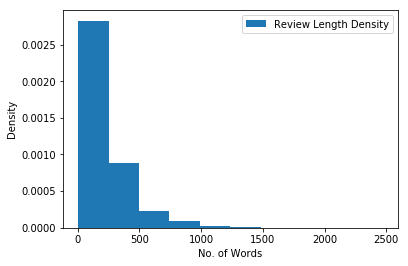

In [7]:
# Count the average length of the reviews in terms of no. of tokens
review_length = []
for review in df.iloc[:,3]:
    review_length.append(len(review.split()))

print("The AVERAGE LENGTH of the reviews is: " + str(np.mean(review_length)))

# Density distribution of review length
plt.hist(review_length, density = True, label = 'Review Length Density')
plt.xlabel('No. of Words')
plt.ylabel('Density')
plt.legend(loc='best')
plt.show()

## Lexicon Approach - VADER used

In [8]:
analyzer_var = SentimentIntensityAnalyzer()
pol_score_docu_set = []
def lexicon_sentiment_vader(document_set):
    for doc in document_set:
        pol_score_doc = analyzer_var.polarity_scores(doc)
        pol_score_docu_set.extend([pol_score_doc.values()]) 
    return pol_score_docu_set
sentiment_predicted = list(lexicon_sentiment_vader(df.iloc[:,3]))

#Sequence: neg, neu, pos, compound

In [9]:
list(sentiment_predicted[0])

[0.121, 0.737, 0.142, 0.4217]

In [10]:
# Apending results to the original dataframe
sentiment_predicted_list = list()

for row in sentiment_predicted:
    compound_score = list(row)[3]
    sentiment_predicted_list.append(compound_score)
df['sentiment_predicted_vader_score'] = pd.Series(sentiment_predicted_list)

In [11]:
# How many Positive, Negative and Neutral reviews present
print('Neutral Reviews')
print(len(df['sentiment_predicted_vader_score'][df['sentiment_predicted_vader_score'] == 0]))

print('Positive Reviews')
print(len(df['sentiment_predicted_vader_score'][df['sentiment_predicted_vader_score'] > 0]))

print('Negative Reviews')
print(len(df['sentiment_predicted_vader_score'][df['sentiment_predicted_vader_score'] < 0]))

Neutral Reviews
30
Positive Reviews
32316
Negative Reviews
16778


In [12]:
# Classifying reviews as Positive or Negative (as mentioned in the question)
# Assumption - Here, I am assuming that score = 0 is also negative
df['sentiment_predicted_vader'] = ['positive' if score > 0 else 'negative' for score in df['sentiment_predicted_vader_score']]

In [13]:
# Building the confusion matrix using sklearn
print('Confusion Matrix for Lexicon Approach (VADER):')
cm = confusion_matrix(df['sentiment'], df['sentiment_predicted_vader'])
print(cm)

Confusion Matrix for Lexicon Approach (VADER):
[[13286 11389]
 [ 3522 20927]]


In [14]:
# Double checking the position of values in the sklearn confusion matrix
df_pred_neg = df[ df[ 'sentiment_predicted_vader'] == 'negative' ]
df_pred_pos = df[ df[ 'sentiment_predicted_vader'] == 'positive' ]
TN =  len( df_pred_neg[df_pred_neg['sentiment'] == 'negative'] ) # TN cm[0][0]
FP =  len( df_pred_neg[df_pred_neg['sentiment'] == 'positive'] ) # FP cm[1][0]
FN =  len( df_pred_pos[df_pred_pos['sentiment'] == 'negative'] ) # FN cm[0][1]
TP =  len( df_pred_pos[df_pred_pos['sentiment'] == 'positive'] ) # TP cm[1][1]
print(TN, FP, FN, TP)

13286 3522 11389 20927


In [15]:
#Defining performance measures from scratch as I don't trust the available packages based on my experiences
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fn, fp, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fn, fp, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fn, fp, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

In [16]:
#Calculating the Accuracy, Sensitivity, and Specificity of Lexicon approach
accuracy = custom_accuracy_score(df['sentiment'], df['sentiment_predicted_vader'])
sensitivity = custom_sensitivity_score(df['sentiment'], df['sentiment_predicted_vader'])
specificity = custom_specificity_score(df['sentiment'], df['sentiment_predicted_vader'])
print('Accuracy Lexicon (Vader): ' + str(accuracy))
print('Sensitivity Lexicon (Vader): ' + str(sensitivity))
print('Specificity Lexicon (Vader): ' + str(accuracy))

Accuracy Lexicon (Vader): 0.6964620144939337
Sensitivity Lexicon (Vader): 0.6475739571729174
Specificity Lexicon (Vader): 0.6964620144939337


## Machine Learning Approach - multiple classifiers and hyperparameter-tuning used

## Tokenize

In [17]:
def simple_tokenize(document_set):
    for doc in document_set:
        yield [w for w in (gensim.utils.tokenize(str(doc), deacc=True))]

get_ipython().run_line_magic('time', 'tokenized_df = list(simple_tokenize(df.iloc[:,3]))')

# Visualize cleansed and tokenized output 
print(list(tokenized_df[0]))

Wall time: 20.3 s
['To', 'sum', 'this', 'movie', 'up', 'it', 'is', 'LaBute', 'carrying', 'his', 'sadism', 'over', 'into', 'the', 'realm', 'of', 'comedic', 'farce', 'The', 'predictable', 'result', 'is', 'that', 'he', 'is', 'constantly', 'stepping', 'on', 'all', 'the', 'jokes', 'by', 'insisting', 'on', 'surrounding', 'them', 'with', 'blood', 'curdling', 'violence', 'and', 'extremely', 'hateful', 'characters', 'There', 'is', 'also', 'evidence', 'of', 'his', 'continuing', 'efforts', 'to', 'insult', 'and', 'ridicule', 'everything', 'in', 'sight', 'but', 'then', 'to', 'apologize', 'for', 'it', 'with', 'weak', 'gestures', 'to', 'the', 'PC', 'Basically', 'the', 'movie', 'just', 'doesn', 't', 'work', 'its', 'plot', 'is', 'beyond', 'contrived', 'the', 'characters', 'are', 'one', 'dimensional', 'cliches', 'there', 'is', 'no', 'consistency', 'or', 'development', 'of', 'anything', 'and', 'the', 'comedy', 'where', 'it', 'is', 'not', 'totally', 'out', 'of', 'place', 'is', 'the', 'worst', 'kind', 'of'

## Stop words removal

In [18]:
def lowercase_remove_stopwords_tokenize(document_set): 
    stop_words = stopwords.words('english')
    stop_words.extend(['br','film','films','movie','movies','see','saw','watch','watched','watches','look','looks','looked'])# Defining list of stopwords to use
    for doc in document_set:
        yield [w for w in (gensim.utils.simple_preprocess(str(doc), deacc=True, min_len = 3)) if w not in stop_words]

get_ipython().run_line_magic('time', 'tokenized_df = list(lowercase_remove_stopwords_tokenize(tokenized_df))')

# Visualize cleansed and tokenized output 
print(list(tokenized_df[0]))

Wall time: 44.3 s
['sum', 'labute', 'carrying', 'sadism', 'realm', 'comedic', 'farce', 'predictable', 'result', 'constantly', 'stepping', 'jokes', 'insisting', 'surrounding', 'blood', 'curdling', 'violence', 'extremely', 'hateful', 'characters', 'also', 'evidence', 'continuing', 'efforts', 'insult', 'ridicule', 'everything', 'sight', 'apologize', 'weak', 'gestures', 'basically', 'work', 'plot', 'beyond', 'contrived', 'characters', 'one', 'dimensional', 'cliches', 'consistency', 'development', 'anything', 'comedy', 'totally', 'place', 'worst', 'kind', 'high', 'concept', 'drivel', 'morgan', 'freeman', 'renee', 'zellweger', 'completely', 'wasted', 'characters', 'seem', 'like', 'parodies', 'studio', 'driven', 'audience', 'pandering', 'matter', 'make', 'likeable', 'neutral', 'neutered', 'full', 'moral', 'platitudes', 'crispin', 'glover', 'long', 'enough', 'convince', 'belong', 'anymore', 'chris', 'rock', 'actually', 'negative', 'chemistry', 'fellow', 'hitman', 'freeman', 'acting', 'differen

## Stemming

In [19]:
#We tried with all the below stemmers  but snowball gave us best results
def snowball_stemming(document_set):
    snowball = nltk.stem.SnowballStemmer('english')
    for doc in document_set:
        yield [snowball.stem(w) for w in doc]

def porter_stemming(document_set):
    porter = nltk.stem.PorterStemmer(mode='NLTK_EXTENSIONS')
    for doc in document_set:
        yield [porter.stem(w) for w in doc]

def lancaster_stemming(document_set):
    lancaster = nltk.stem.LancasterStemmer()
    for doc in document_set:
        yield [lancaster.stem(w) for w in doc]

get_ipython().run_line_magic('time', 'stemmed_df = list(snowball_stemming(tokenized_df))') #Using Snowball stemmer

# Visualize cleansed and tokenized output 
print(list(stemmed_df[0]))

Wall time: 1min 3s
['sum', 'labut', 'carri', 'sadism', 'realm', 'comed', 'farc', 'predict', 'result', 'constant', 'step', 'joke', 'insist', 'surround', 'blood', 'curdl', 'violenc', 'extrem', 'hate', 'charact', 'also', 'evid', 'continu', 'effort', 'insult', 'ridicul', 'everyth', 'sight', 'apolog', 'weak', 'gestur', 'basic', 'work', 'plot', 'beyond', 'contriv', 'charact', 'one', 'dimension', 'clich', 'consist', 'develop', 'anyth', 'comedi', 'total', 'place', 'worst', 'kind', 'high', 'concept', 'drivel', 'morgan', 'freeman', 'rene', 'zellweg', 'complet', 'wast', 'charact', 'seem', 'like', 'parodi', 'studio', 'driven', 'audienc', 'pander', 'matter', 'make', 'likeabl', 'neutral', 'neuter', 'full', 'moral', 'platitud', 'crispin', 'glover', 'long', 'enough', 'convinc', 'belong', 'anymor', 'chris', 'rock', 'actual', 'negat', 'chemistri', 'fellow', 'hitman', 'freeman', 'act', 'differ', 'room', 'even', 'two', 'inch', 'away', 'effect', 'chris', 'rock', 'seem', 'like', 'digit', 'insert', 'least', 

## Bi-grams

In [20]:
#Using gensim's 'Phrases' class functions
def bi_grams(document_set):
        bi_gram_mod = gensim.models.Phrases(document_set, min_count=5, threshold=100) #the bigram should appear min min_count times in the corpus
        return bi_gram_mod
        #Phraser is a wrapper that is faster compared to the Phrases class, but we decided not to use it

get_ipython().run_line_magic('time', 'bi_grams_df = bi_grams(stemmed_df)[stemmed_df]')
                   
# Visualize bigram output
print(bi_grams_df[0]) 

Wall time: 7.93 s
['sum', 'labut', 'carri', 'sadism', 'realm', 'comed', 'farc', 'predict', 'result', 'constant', 'step', 'joke', 'insist', 'surround', 'blood_curdl', 'violenc', 'extrem', 'hate', 'charact', 'also', 'evid', 'continu', 'effort', 'insult', 'ridicul', 'everyth', 'sight', 'apolog', 'weak', 'gestur', 'basic', 'work', 'plot', 'beyond', 'contriv', 'charact', 'one', 'dimension', 'clich', 'consist', 'develop', 'anyth', 'comedi', 'total', 'place', 'worst', 'kind', 'high', 'concept', 'drivel', 'morgan_freeman', 'rene_zellweg', 'complet', 'wast', 'charact', 'seem', 'like', 'parodi', 'studio', 'driven', 'audienc', 'pander', 'matter', 'make', 'likeabl', 'neutral', 'neuter', 'full', 'moral', 'platitud', 'crispin_glover', 'long', 'enough', 'convinc', 'belong', 'anymor', 'chris_rock', 'actual', 'negat', 'chemistri', 'fellow', 'hitman', 'freeman', 'act', 'differ', 'room', 'even', 'two', 'inch', 'away', 'effect', 'chris_rock', 'seem', 'like', 'digit', 'insert', 'least', 'annoy', 'jar_jar',

## Tri-grams

In [21]:
#Assumption - The output of bi_grams function would be passed to this function as an input
def tri_grams(document_set):
        tri_gram_mod = gensim.models.Phrases(document_set, min_count=3, threshold=100) #the trigram should appear min min_count times in the corpus
        return tri_gram_mod
        #Phraser is a wrapper that is faster compared to the Phrases class, but we decided not to use it

get_ipython().run_line_magic('time', 'tri_grams_df = tri_grams(bi_grams_df)[bi_grams_df] #Notice how bi_grams_df was given as an input')
                   
# Visualize trigram output
print(tri_grams_df[0])  

Wall time: 26.4 s
['sum', 'labut', 'carri', 'sadism', 'realm', 'comed', 'farc', 'predict', 'result', 'constant', 'step', 'joke', 'insist', 'surround', 'blood_curdl', 'violenc', 'extrem', 'hate', 'charact', 'also', 'evid', 'continu', 'effort', 'insult', 'ridicul', 'everyth', 'sight', 'apolog', 'weak', 'gestur', 'basic', 'work', 'plot', 'beyond', 'contriv', 'charact', 'one', 'dimension', 'clich', 'consist', 'develop', 'anyth', 'comedi', 'total', 'place', 'worst', 'kind', 'high', 'concept', 'drivel', 'morgan_freeman', 'rene_zellweg', 'complet', 'wast', 'charact', 'seem', 'like', 'parodi', 'studio', 'driven', 'audienc', 'pander', 'matter', 'make', 'likeabl', 'neutral', 'neuter', 'full', 'moral', 'platitud', 'crispin_glover', 'long', 'enough', 'convinc', 'belong', 'anymor', 'chris_rock', 'actual', 'negat', 'chemistri', 'fellow', 'hitman', 'freeman', 'act', 'differ', 'room', 'even', 'two', 'inch', 'away', 'effect', 'chris_rock', 'seem', 'like', 'digit', 'insert', 'least', 'annoy', 'jar_jar',

## Some more Stop-words removal

In [22]:
def remove_stopwords(document_set): 
    stop_words_x = ['find', 'back', 'another', 'becom','sinc','later','includ','away','use','feel','may','howev','enough','see','might','found',
                    'effect','viewer','let','also','much','mani','seem','give','though','done','must','make','made','get', 'realli','would','even','way','peopl','think','made','know','thing','could',
                    'say','come','still','part','want','tri','actual','especi','around','version','keep','soon','check','eventu','lot','exampl','exact','realiz','describ','refer','serv','edg','assum','seen','ever','agre','prefer','vari','rate','came','piec','deserv','aw','asid','toward','imdb','yeah','alway','sure','par','apart','genr','situat','provid','explan'
                    'around','later','goe','portray','open','came','became','alreadi','ask','return','wait','continu',
                    'anoth','believ','bit','thought', 'pretti','take','never', 'watch','everi','got','point','fact','without','need','person','almost','yet','tell','line','kind','whole','course','expect','probabl','main','less','sort','cut','pick','rememb','often','throughout','number','attempt','near','cannot','gave',
                    'anyway','across','becam','help','follow','look','said','other','topic','somebodi','sat','everyon','easili','listen','reach','alter','truli','went','side','knew','subject','otherwis','affect','belong','intent','improv','angle','talki','hey','pleas','add'         
                    'time','someth','noth','place','put','although','moment','anyth','happen','view','cours','far','reason','name','well','rather','complet','appear','gener','creat','along','featur','differ','understand','bring','word','comment','sometim','next','possibl','theme','anyon','simpli','imagin','abl','talk','heard','notic','inde','remind','occur','convey','establish','compel','neg','capabl','due','prove','mostli','regard','discuss','onto','moreov','relat','unfold','convinc','beyond','consist','essenti','instanc','damn','anymor','insist','frankli','manner','conduct','spoke','compris','familiar','kept','necessari','descript',
                    'day','right','leave','felt','learn','manag','captur','full','simpl','known','shown','form','whose','audienc','present','remain','hear','somoewhat','self','rel','latter','angl','consider','earlier','enter','among','inform','constantli','evid','seek','meant','observ','intend','question','type','process','sourc','chose','thank','highlight','pre',
                    'two','focus','geniu','supposedli','deepli','hardli','pure','furthermor','somewher','first','last','one','non','pass','certain','time','valu','review','today','gone','score','began','mayb','yes','either','mention','recal','express','numer','thorough','non','certain','true','remark','encount', 'experi','time','valu','review','today','gone','score','began','mayb','yes','either','mention','numer','nobodi','ampl',
                    'understood','mere','contain','random','choic','interpret','attent',
                    'besid','idea','cant','can','skip','dude','guess','overal','core','kinda'
                    'potenti','wonder','rest','year','mix','hour','six',
                    'somewhat','three','display','prepar','stuff','certainli'
                    'year_ago','insid','despit','neither','step']
    for doc in document_set:
        yield [w for w in (gensim.utils.simple_preprocess(str(doc), deacc=True, min_len = 3)) if w not in stop_words_x]

#lowercase_remove_stopwords_tokenize returns a generator object, and using list() causes it to apply the generator on the data df
get_ipython().run_line_magic('time', 'tri_grams_df_2= list(remove_stopwords(tri_grams_df))')

# Visualize cleansed and tokenized output 
print(list(tri_grams_df_2[0]))


Wall time: 1min 8s
['sum', 'labut', 'carri', 'sadism', 'realm', 'comed', 'farc', 'predict', 'result', 'constant', 'joke', 'surround', 'blood_curdl', 'violenc', 'extrem', 'hate', 'charact', 'effort', 'insult', 'ridicul', 'everyth', 'sight', 'apolog', 'weak', 'gestur', 'basic', 'work', 'plot', 'contriv', 'charact', 'dimension', 'clich', 'develop', 'comedi', 'total', 'worst', 'high', 'concept', 'drivel', 'morgan_freeman', 'rene_zellweg', 'wast', 'charact', 'like', 'parodi', 'studio', 'driven', 'pander', 'matter', 'likeabl', 'neutral', 'neuter', 'moral', 'platitud', 'crispin_glover', 'long', 'chris_rock', 'negat', 'chemistri', 'fellow', 'hitman', 'freeman', 'act', 'room', 'inch', 'chris_rock', 'like', 'digit', 'insert', 'least', 'annoy', 'jar_jar', 'labut', 'minut', 'like', 'overstay_welcom']


## De-tokenizing because CountVectorizer takes as input only strings

In [23]:
def de_tokenize(document_set):
    dummy_list = []
    for doc in document_set:
        dummy_list.append(str([' '.join(doc)]))
    return dummy_list
tri_grams_df_3 = de_tokenize(tri_grams_df_2)

In [24]:
type(tri_grams_df_3[0])

str

## Converting sentiment from categorical values to numerical values : 0 (negative) and 1 (positive)

In [25]:
df['sentiment_onehot'] = [0 if value == 'negative' else 1 for value in df['sentiment']]
print(df['sentiment_onehot'].value_counts())

0    24675
1    24449
Name: sentiment_onehot, dtype: int64


## Train-Test-Validate Split

I'm taking a 20% hold-out set for Validation (Train-Test-Validation - 3 total sets)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(tri_grams_df_3, df['sentiment_onehot'], test_size = 0.2)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

39299
9825
39299
9825


In [27]:
type(X_train[0])

str

In [35]:
# A function to plot ROC curve of different ML classifiers - ref. https://stackoverflow.com/questions/47569394/the-graph-of-this-roc-curve-looks-strange-sklearn-svc
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show();

In [36]:
X_train_backup = X_train
X_test_backup = X_test

In [88]:
# X_train =  X_train_backup
# X_test = X_test_backup

## Vectorizing reviews into vectors - CountVectorizer

In [89]:
count_vectorizer = CountVectorizer(analyzer = 'word', tokenizer = None, lowercase = False, min_df = 15, max_df = 0.3)
count_vectorizer.fit(X_train)
X_train = count_vectorizer.transform(X_train)
X_test = count_vectorizer.transform(X_test)

In [90]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39299, 12803)
(9825, 12803)
(49124,)
(9825,)


## Vectorizing reviews into vectors - TFIDF Vectorizer

In [39]:
X_train_tfidf = X_train_backup
X_test_tfidf = X_test_backup
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', tokenizer = None, lowercase = False, min_df = 15, max_df = 0.3)
tfidf_vectorizer.fit(X_train_tfidf)
X_train_tfidf = tfidf_vectorizer.transform(X_train_tfidf)
X_test_tfidf = count_vectorizer.transform(X_test_tfidf)

In [40]:
X_train_tfidf.shape

(39299, 12803)

## Building Classifier models - GridSearchCV and 10-fold CV (CountVectorized Features)

In [46]:
# Model training Logistic Regssion
classifier_LR = LogisticRegression(random_state = 0)

# # Model training K-NN
# classifier_KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# # Model training SVM
# classifier_SVM = SVC(C = 1.0, kernel = 'linear', random_state = 0)

# Model training Naive Bayes
# classifier_NB = GaussianNB()

# Model training Random Forest
classifier_RF = RandomForestClassifier(n_estimators = 10, criterion='entropy', random_state = 0)

# Model training Decision Tree
# from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

# Model training Kernel SVM
# from sklearn.svm import SVC
# classifier_K_SVM = SVC(C = 1.0, kernel = 'rbf', gamma = 'auto', random_state = 0)

# Applying GridSearch Cross Validation to find out best mean accuracies of various models
y_train = np.asarray(y_train, dtype = float )
y_test = np.asarray(y_test, dtype = float )
classifiers_list = [
                   (classifier_LR,'classifier_LR'), #(classifier_SVM,'classifier_SVM'), #(classifier_KNN,'classifier_KNN'), 
                   #(classifier_NB,'classifier_NB'), 
                   (classifier_RF,'classifier_RF'),
                   (classifier_DT,'classifier_DT'), #(classifier_K_SVM,'classifier_K_SVM') 
                    ]
# Grid-Search
Grid_srch_parameters_list = [ [{'C': [0.01, 0.1, 0.5, 1.0, 10, 100], 'class_weight': ['balanced']}],
#                             [{'n_neighbors':[3,5],'weights':['uniform'],'p':[1]}],
#                             [{'C':[1.0],'kernel':['linear']}],
                            #[{}],
                            [{'n_estimators':[5,10],'criterion':['entropy','gini']}], 
                            [{'criterion':['entropy','gini'], 'max_features':['auto','sqrt','log2']}],
#                             [{'C':[1.0],'kernel':['rbf'],'gamma':['auto']}]
                            ]

#GridSearchCV custom scorer definition
score_func = make_scorer(custom_accuracy_score, greater_is_better=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
No handles with labels found to put in legend.


Showing performance of classifier_LR
Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Confusion Matrix: 
[[4302  679]
 [ 597 4247]]
****BEST ACC: 0.8772487849563602
*SENSITIVITY: 0.8621599675192855
*SPECIFICITY: 0.8781383955909369


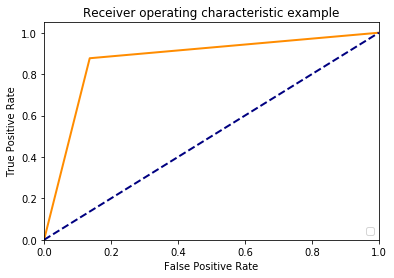

No handles with labels found to put in legend.


Showing performance of classifier_RF
Best parameters: {'criterion': 'entropy', 'n_estimators': 10}
Confusion Matrix: 
[[4175  806]
 [1171 3673]]
****BEST ACC: 0.7942186824092216
*SENSITIVITY: 0.8200491181067202
*SPECIFICITY: 0.7809577254021699


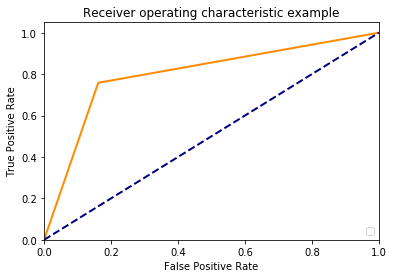

No handles with labels found to put in legend.


Showing performance of classifier_DT
Best parameters: {'criterion': 'entropy', 'max_features': 'auto'}
Confusion Matrix: 
[[3698 1283]
 [1296 3548]]
****BEST ACC: 0.6966843940049365
*SENSITIVITY: 0.7344235148002484
*SPECIFICITY: 0.7404885863035643


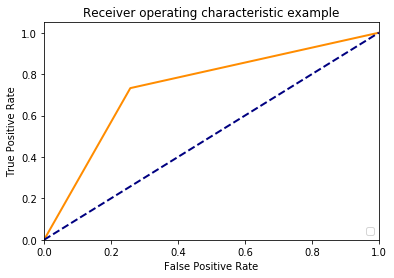

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

i, length = 0, len(classifiers_list) + 1
for clf in classifiers_list:
    # Fitting classifier to training data
    clf[0].fit(X_train, y_train)
    # Predicting output
    y_pred = clf[0].predict(X_test)
    grid_search = GridSearchCV(estimator = clf[0], param_grid = Grid_srch_parameters_list[i], scoring = score_func,cv = 10)
    grid_search = grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    print('Showing performance of ' + clf[1])
    print('Best parameters: ' + str(grid_search.best_params_))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n" + str(cm)) #Actual on the Left, Pred at the Top
    print("****BEST ACC: " + str(grid_search.best_score_))
    print("*SENSITIVITY: " + str(custom_sensitivity_score(y_test, y_pred)))
    print("*SPECIFICITY: " + str(custom_specificity_score(y_test, y_pred)))
    plot_roc(y_test, y_pred)
    i=i+1

## Building Classifier models - GridSearchCV and 10-fold CV (TFIDF Vectorized Features)

In [50]:
# Model training Logistic Regssion
classifier_LR = LogisticRegression(random_state = 0)

# # Model training K-NN
# classifier_KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# # Model training SVM
# classifier_SVM = SVC(C = 1.0, kernel = 'linear', random_state = 0)

# Model training Naive Bayes
# classifier_NB = GaussianNB()

# Model training Random Forest
classifier_RF = RandomForestClassifier(n_estimators = 10, criterion='entropy', random_state = 0)

# Model training Decision Tree
# from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

# Model training Kernel SVM
# from sklearn.svm import SVC
# classifier_K_SVM = SVC(C = 1.0, kernel = 'rbf', gamma = 'auto', random_state = 0)

# Applying GridSearch Cross Validation to find out best mean accuracies of various models
# y_train = np.asarray(y_train, dtype = float )
# y_test = np.asarray(y_test, dtype = float )
classifiers_list = [
                   (classifier_LR,'classifier_LR'), #(classifier_SVM,'classifier_SVM'), #(classifier_KNN,'classifier_KNN'), 
                   #(classifier_NB,'classifier_NB'), 
                   (classifier_RF,'classifier_RF'),
                   (classifier_DT,'classifier_DT'), #(classifier_K_SVM,'classifier_K_SVM') 
                    ]
# Grid-Search
Grid_srch_parameters_list = [ [{'C': [0.01, 0.1, 0.5, 1.0, 10, 100], 'class_weight': ['balanced']}],
#                             [{'n_neighbors':[3,5],'weights':['uniform'],'p':[1]}],
#                             [{'C':[1.0],'kernel':['linear']}],
                            #[{}],
                            [{'n_estimators':[5,10],'criterion':['entropy','gini']}], 
                            [{'criterion':['entropy','gini'], 'max_features':['auto','sqrt','log2']}],
#                             [{'C':[1.0],'kernel':['rbf'],'gamma':['auto']}]
                            ]

#GridSearchCV custom scorer definition
score_func = make_scorer(custom_accuracy_score, greater_is_better=True)


No handles with labels found to put in legend.


Showing performance of classifier_LR
Best parameters: {'C': 1.0, 'class_weight': 'balanced'}
Confusion Matrix: 
[[3698 1283]
 [1296 3548]]
****BEST ACC: 0.8807603246901957
*SENSITIVITY: 0.7344235148002484
*SPECIFICITY: 0.7404885863035643


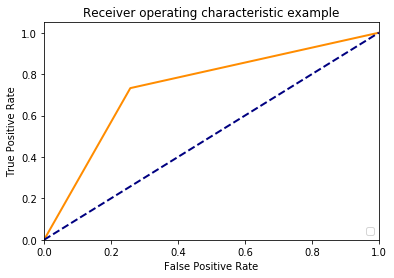

No handles with labels found to put in legend.


Showing performance of classifier_RF
Best parameters: {'criterion': 'entropy', 'n_estimators': 10}
Confusion Matrix: 
[[3698 1283]
 [1296 3548]]
****BEST ACC: 0.7970177358202499
*SENSITIVITY: 0.7344235148002484
*SPECIFICITY: 0.7404885863035643


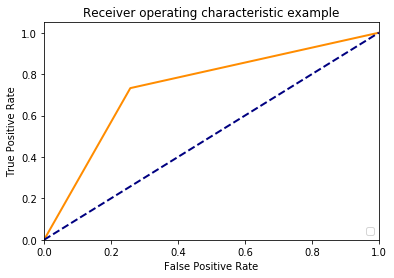

No handles with labels found to put in legend.


Showing performance of classifier_DT
Best parameters: {'criterion': 'entropy', 'max_features': 'auto'}
Confusion Matrix: 
[[3698 1283]
 [1296 3548]]
****BEST ACC: 0.6989236367337591
*SENSITIVITY: 0.7344235148002484
*SPECIFICITY: 0.7404885863035643


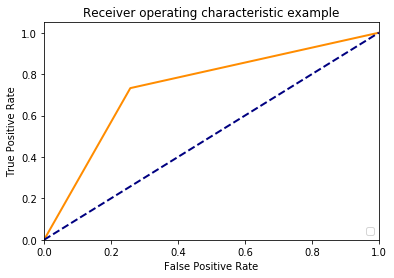

In [51]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

i, length = 0, len(classifiers_list) + 1
for clf in classifiers_list:
    # Fitting classifier to training data
    clf[0].fit(X_train_tfidf, y_train)
    # Predicting output
    y_pred_tfidf = clf[0].predict(X_test_tfidf)
    grid_search = GridSearchCV(estimator = clf[0], param_grid = Grid_srch_parameters_list[i], scoring = score_func,cv = 10)
    grid_search = grid_search.fit(X_train_tfidf, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    print('Showing performance of ' + clf[1])
    print('Best parameters: ' + str(grid_search.best_params_))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n" + str(cm)) #Actual on the Left, Pred at the Top
    print("****BEST ACC: " + str(grid_search.best_score_))
    print("*SENSITIVITY: " + str(custom_sensitivity_score(y_test, y_pred)))
    print("*SPECIFICITY: " + str(custom_specificity_score(y_test, y_pred)))
    plot_roc(y_test, y_pred)
    i=i+1

## Pulling out specific reviews as examples

## Both correct

Example 1: Where both ML and Lexicon were correct

In [119]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[0]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[0] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Negative


In [70]:
#Print review:
X_test_backup[0]

"['slouch redeem social whatev book suppress huck finn heart dark deep throat latest hostag behead sincer wish lover porn violenc entertain chanc upon tend camera_angl pan light rhythm exclus fear titil miss filmmak actor footag argu exist wrong wiser harder deconstruct unpleas cinema pan etc insepar matter content horror filmmak church architect common add polit filmmak fascist manipul light space sound order percept mood goal goal real atroc propaganda origin night long anl trilog shelf left unwatch curios buy sampl minut arriv awkward sound street corner stab attack sensibl inept relish prospect clear sublim horror kairo cure angel dust lain rawer tradit frame horror evil dead trap overt polit work koji wakamatsu brilliant cruditi earli cronenberg attack key matsumura attack charact histori abu garib evidenc video hostag video godard tortur petit soldat atroc job fraction workday prolong news stori detail bare entir forget entail cinema duo serial_killer notori suggest play game mem

Example 2: Where both ML and Lexicon were correct

In [124]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[3]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[3] == 0 else 'Positive')

Lexicon Prediction: 
Positive
LogisticRegression Prediction: 
Positive


In [126]:
#Print review:
X_test_backup[3]

"['episod friend introduc control freak monica gellar courtney_cox newli divorc ross gellar david schimmer hippi pheob buffay lisa_kudrow unknown actor ladi man matt blanc sarcast chandler bing matthew_perri scene start introduc final friend spoilt kid rachel green jennif_aniston episod better credit like new sitcom episod fantast act episod great cast identifi arnt new charact kudrow perri shine matt blanc man act dread confid funni fail david schimmer pronounc speak normal funniest charact season confid sympathis jennif_aniston hot good job rachel green real rachel season courtney_cox quit anorex episod worri total healthili act littl sketchi minut pilot lisa_kudrow matthew_perri togeth comic act qualiti superb lisa role natur pheob pheeb matthew_perri matthew_perri play basic episod qualiti set dark creepi episod unfriend act charact gain confid new scene proud pilot hope friend reunit caus']"

Example 3: Where both ML and Lexicon were correct

In [128]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[11]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[11] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Negative


In [129]:
#Print review:
X_test_backup[11]

"['lack content amaz compar rock surpris worst rock stori horribl cast ajay_devgan jam salman_khan asin gotta kid music okay khanabadosh track bad vipul_shah singh king critic bash comedi asin sorri asin fan suck big serious bad act good overdos final_verdict aladin famili instead wast']"

## ML correct, Lexicon wrong

Example 1: Where ML was correct, but Lexicon was wrong

In [127]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[10]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[10] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Positive


In [130]:
#Print review:
X_test_backup[10]

"['enjoy grant enjoy sean_conneri act ad_bonus harri stori grandma conneri assist grandson prison wrong convict racist aspect case turn offic case black bad coerc confess boy boy killer lock prison death particular nasti joy write victim mail twist turn unexpect enjoy sean_conneri charact sens ordeal mad area ultim good interplay conneri harri shine end good suspens thriller']"

Example 2: Where ML was correct, but Lexicon was wrong

In [157]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[51]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[51] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Positive


In [156]:
#Print review:
X_test_backup[51]

"['fascin documentari old black lad accus murder tourist florida subsiqu court case show corrupt american polic system easi convict innoc man senil old fool black man like sod rot jail man murder wife star defenc lawyer brilliant job court polic fascin']"

Example 3: Where ML was correct, but Lexicon was wrong

In [173]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[57]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[57] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Positive


In [174]:
#Print review:
X_test_backup[57]

"['stori friendship shook south_africa awaken world direct bridg gandhi stori steve_biko life journey troubl journalist donald_wood order stori told wood book basi biko troubl late south_africa south_africa grip terribl apartheid black separ white classifi white superior race black forc live shantytown outskirt citi town frequent harass polic armi dawn raid shantytown bulldoz arm polic forc camp beat kill inhabit introduc donald_wood kevin_kline editor popular newspap publish negat stori black wood meet wari good friend biko show horror apartheid system black wood encourag wood speak desper steve_biko stori clutch white man south_africa world steve_biko arrest kill prison wood famili dare escap south_africa england wood publish book steve_biko apartheid cri_freedom impress dedic life steve_biko steve_biko event stori donald_wood journey border lesotho elud south_african offici wood five hous arrest steve_biko kill order publish manuscript steve_biko escap manuscript consid treason sout

## Lexicon correct, ML wrong

Example 1: Where Lexicon was correct, but ML was wrong

In [131]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[15]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[15] == 0 else 'Positive')

Lexicon Prediction: 
Positive
LogisticRegression Prediction: 
Negative


In [132]:
#Print review:
X_test_backup[15]

"['sad someon good end mediocr jordan play basebal appli steve_martin act direct script stinker martin great job adapt classic stori comedi roxann effort victorian drama contemporari scene smack straight wall implaus old stori updat style best rent great']"

Example 2: Where Lexicon was correct, but ML was wrong

In [143]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[20]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[20] == 0 else 'Positive')

Lexicon Prediction: 
Positive
LogisticRegression Prediction: 
Negative


In [144]:
#Print review:
X_test_backup[20]

"['dolph_lundgren brood scowl incoher mysteri thriller cool box quit good stori mess clich detect reveng tycoon hooker like second half decent lundgren flick rent red scorpion instead']"

Example 3: Where Lexicon was correct, but ML was wrong

In [150]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[27]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[27] == 0 else 'Positive')

Lexicon Prediction: 
Positive
LogisticRegression Prediction: 
Negative


In [149]:
#Print review:
X_test_backup[27]

"['pegg hit past start shaun_dead hot_fuzz earli run fat boy run lose friend alien favourit comedi sidney yound man write fail magazin fun celebr most success magazin owner play jeff_bridg invit nostalgia work magazin sidney excit move america meet girl current write book hilar_ensu great hope like futur pegg given everywher good third blood ice_cream trilog paul']"

## Both wrong

In [ ]:
Example 1: Where both ML and Lexicon were wrong

In [121]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[1]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[1] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Negative


In [122]:
#Print review:
X_test_backup[1]

"['curios led masterpiec unfortun rent bought disturb disturb maker set show human jeffri dahmer kid man new mean term finger lickin good flash flash_forward troubl stori jeremi renner perform bad catch play disgruntl cop renner perform plenti book documentari better job cover dahmer crime avoid']"

Example 2: Where both ML and Lexicon were wrong

In [164]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[54]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[54] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Negative


In [165]:
#Print review:
X_test_backup[54]

"['hope suggest american friend finish close war long patriot critic like flat loc forget budget preclud director intellig length bad repetit attack hill loc terribl terrain hill like backyard charact develop sequenc soilder flashback deploy clump long memori end better call border']"

Example 3: Where both ML and Lexicon were wrong

In [175]:
#Lexicon prediction
print('Lexicon Prediction: ')
print('Negative' if list(analyzer_var.polarity_scores(X_test_backup[56]).values())[3] <= 0 else 'Positive')

#ML prediction
print('LogisticRegression Prediction: ')
print('Negative' if y_pred[56] == 0 else 'Positive')

Lexicon Prediction: 
Negative
LogisticRegression Prediction: 
Negative


In [176]:
#Print review:
X_test_backup[56]

"['howl introduc world werewolv exist organ plot sens report investig uncov truth end kill boyfriend show world exist transform live special_effect laughabl better whether transform bad puppet cheesi comput_graphic show superpow plot bad kill leader werewolv destroy werewolv end threat werewolv kill cloudi lost end minut montaug scene femal werewolf leader rip top expos larg breast devo esquir band play crowd werewolv watchabl christoph_lee']"

## Things I wanted to try

In [ ]:
id2word_lda = gensim.corpora.Dictionary(tri_grams_df_2)
print(len(id2word_lda))

In [ ]:
id2word_lda.filter_extremes(no_below=15, no_above=0.85, keep_n=100000) # 
print(len(id2word_lda))

In [ ]:
# Term document frequency =; Bag of words representation
corpus_lda = [id2word_lda.doc2bow(doc) for doc in tri_grams_df_2]
print(corpus_lda[0])

In [ ]:
tfidf = TfidfModel(corpus_lda)
corpus_lda_tfidf = tfidf[corpus_lda]

References:
VADER paper: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
Vader: http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html
ROC curve: https://stackoverflow.com/questions/47569394/the-graph-of-this-roc-curve-looks-strange-sklearn-svc
Some of the standard code used here has been fetched from my earlier assignments/projects. Those codes were created by me.